# Его величество, "домашка №1"

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [2]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets livelossplot

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from huggingface_hub import hf_hub_download

In [4]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [5]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



In [6]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw1"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

Homework repository: 'Pavelslavovich/llm-course-hw1'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [7]:
dataset = load_dataset("IgorVolochay/russian_jokes")
print("\n===\n".join(dataset["train"]["text"][:3]))

- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!
===
После проведения акции "К животным по-человечески" животные посовещались и решили провести акцию "К человеку по-скотски".
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.


In [8]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 135497
    })
    test: Dataset({
        features: ['text'],
        num_rows: 15056
    })
})

# Токенизатор [6 баллов]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [9]:
# Всякие полезности

WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [10]:
def merge(merge_pair: tuple[str, str], pair_frequences: Counter[tuple[str, str]], words_by_tokens: Counter[tuple[str]]):
    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """
    
    new_token = ''.join(merge_pair)

    
    updated_words_by_tokens = Counter()

    
    updated_pair_frequences = Counter()

    
    for word, freq in words_by_tokens.items():
        
        new_word = list(word)
        i = 0

        
        while i < len(new_word) - 1:
            if new_word[i] == merge_pair[0] and new_word[i + 1] == merge_pair[1]:
                new_word[i] = new_token
                new_word.pop(i + 1)
            else:
                i += 1

        
        new_word = tuple(new_word)
        updated_words_by_tokens[new_word] += freq

        
        for i in range(len(new_word) - 1):
            pair = (new_word[i], new_word[i + 1])
            updated_pair_frequences[pair] += freq

    return updated_pair_frequences, updated_words_by_tokens


def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data

    Args:
        data: List of train documents
        vocab_size: Size of target vocabulary
        special_tokens: List of special tokens to add into vocabulary
    Returns:
        vocabulary: mapping from string token to id
        merges: list of merges, each one is tuple of string tokens
    """
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    
    id2token = bytes_to_unicode()
    merges = []

    
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            
            tokens = tuple(id2token[b] for b in word.encode('utf-8'))
            words_by_tokens[tokens] += 1

   
    pair_frequences = Counter()
    for word, freq in words_by_tokens.items():
        for i in range(len(word) - 1):
            pair = (word[i], word[i + 1])
            pair_frequences[pair] += freq

    
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        
        top_pair = max(pair_frequences.items(), key=lambda x: x[1])[0]
        new_token = ''.join(top_pair)
        del pair_frequences[top_pair]

        
        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [11]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!


vocab, merges = train(dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"])

Loading data:   0%|          | 0/135497 [00:00<?, ?it/s]

Building vocabulary:  25%|##5       | 257/1024 [00:00<?, ?it/s]

In [57]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

Token #512: ' Я'
Token #614: ' уже'
Token #768: ' Нет'
Token #888: ' него'
Token #1022: ' голов'


In [12]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        """Process word into tokenized representation.
        Word is a tuple of base tokens, i.e. bytes.

        Under the hood:
        1. Tracks the set of token pairs, bi-grams
        2. While possible, replaces the highest-ranking pair with its union

        Args:
            word: list of base string tokens
        Return:
            list of BPE tokens
        """
        
        word = list(word)

        
        pairs = [(word[i], word[i+1]) for i in range(len(word) - 1)]

        
        while pairs:
            
            best_pair = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float('inf')))

            
            if best_pair not in self.bpe_ranks:
                break

            
            new_token = ''.join(best_pair)

            
            new_word = []
            i = 0
            while i < len(word):
                
                if i < len(word) - 1 and (word[i], word[i+1]) == best_pair:
                    new_word.append(new_token)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1

            
            word = new_word
            pairs = [(word[i], word[i+1]) for i in range(len(word) - 1)]

        return tuple(word)

    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        """Convert string to list of token ids.

        Args:
            text: input string, may contain multiple words
            add_eos_token: whether to add eos token id at the end
        Return:
            list of ints, ids of tokenized text
        """
        words = WHITESPACE_SPLITTER.findall(text)
        ids = []

        for word in words:
            
            byte_tokens = tuple(self.byte_encoder[b] for b in word.encode('utf-8'))
            
            bpe_tokens = self.bpe(byte_tokens)
            
            ids.extend([self.token2id[token] for token in bpe_tokens])

        if add_eos_token:
            ids.append(self.eos_token_id)

        return ids

    def decode(self, idx: list[int]) -> str:
        """Convert list of tokens' ids to text, opposite to encode method

        Args:
            idx: list of tokens' ids
        Return:
            string, decoded text
        """
        
        tokens = [self.id2token[id] for id in idx if id in self.id2token]

        
        if self.eos_token in tokens:
            tokens = tokens[:tokens.index(self.eos_token)]

        
        byte_string = b''
        for token in tokens:
            
            for char in token:
                if char in self.byte_decoder:
                    byte_string += bytes([self.byte_decoder[char]])

        
        text = byte_string.decode('utf-8', errors='replace')

        return text

    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [13]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [14]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Pavelslavovich/llm-course-hw1/commit/f297ded7f6b5659612403144fb586f438503ad83', commit_message='Upload folder using huggingface_hub', commit_description='', oid='f297ded7f6b5659612403144fb586f438503ad83', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Pavelslavovich/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='Pavelslavovich/llm-course-hw1'), pr_revision=None, pr_num=None)

In [15]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

In [16]:


text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[795, 282, 755, 481, 350, 305, 258, 276, 337, 358, 63, 357, 302, 362, 257, 330, 617, 769, 419, 634, 658, 782, 406, 44, 481, 350, 305, 258, 276, 337, 358, 398, 361, 339, 336, 865, 277, 323, 316, 338, 272, 380, 345, 316, 372, 503, 349, 279, 350, 391, 264, 259, 46, 1023]
Ч|то| было| пол|г|од|а| н|аз|ад|?| П|ом|им|о| г|ран|ди|оз|ных| соб|ыт|ий|,| пол|г|од|а| н|аз|ад| бы|ли| е|щ|ё| с|ем|ин|ар|ы| по| л|ин|ей|ной| а|л|г|еб|р|е|.|
Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре.


In [17]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

  0%|          | 0/15056 [00:00<?, ?it/s]

Average token len per sample: 70.42
Minimum and maximum lens are: 5 and 3324


Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [10 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [18]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
}

In [19]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        
        return x / rms * self.scale


class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and ALiBi for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

        # Init projection layers
        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)
        self.kv_proj = nn.Linear(self.config.hidden_dim, 2 * self.config.n_kv_head * self.head_dim, bias=False)
        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))
        self.register_buffer("alibi", self._build_alibi_bias(self.config.n_head))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        """Build ALiBi for specified number of heads:

        Returns:
            Tensor with ALiBi biases, shape: [1, num heads, 1, 1]
        """
        
        slopes = torch.tensor(
            [2 ** -(8 * (i + 1) / num_heads) for i in range(num_heads)]
        ).view(1, num_heads, 1, 1)
        return slopes

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1)
        
        mask = 1.0 - mask
       
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        batch_size, seq_len, hidden_dim = x.shape

        
        q = self.q_proj(x)  

        
        kv = self.kv_proj(x)  
        kv = kv.view(batch_size, seq_len, 2, self.config.n_kv_head, self.head_dim)
        k, v = kv.unbind(dim=2)  

        q = q.view(batch_size, seq_len, self.config.n_head, self.head_dim)

        q = q.transpose(1, 2)  
        k = k.transpose(1, 2)  
        v = v.transpose(1, 2)  

        if self.q_per_kv > 1:
            k = k.repeat_interleave(self.q_per_kv, dim=1)  
            v = v.repeat_interleave(self.q_per_kv, dim=1)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  

        alibi_bias = self.alibi * torch.arange(seq_len, device=x.device).view(1, 1, 1, seq_len)
        attn_scores = attn_scores - alibi_bias

        causal_mask = self.causal_mask[:, :, :seq_len, :seq_len]
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))

        if attention_mask is not None:
            pad_mask = attention_mask.view(batch_size, 1, 1, seq_len)
            attn_scores = attn_scores.masked_fill(pad_mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        out = torch.matmul(attn_weights, v)  

        
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)

        
        out = self.out_proj(out)

        return out


class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        
        self.fc1 = nn.Linear(config.hidden_dim, config.intermediate_dim * 2, bias=False)
        self.fc2 = nn.Linear(config.intermediate_dim, config.hidden_dim, bias=False)

    def forward(self, x: Tensor) -> Tensor:
        """Apply SwiGLU to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        
        x_proj = self.fc1(x)

        
        x_proj_1, x_proj_2 = x_proj.chunk(2, dim=-1)

        swish = x_proj_1 * torch.sigmoid(x_proj_1)

        gate = F.gelu(x_proj_2)

        result = swish * gate

        return self.fc2(result)


class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        attn_input = self.ln_1(x)

        attn_output = self.attn(attn_input, attention_mask)

        x = x + self.res_dropout_1(attn_output)

        mlp_input = self.ln_2(x)

        mlp_output = self.mlp(mlp_input)

        x = x + self.res_dropout_2(mlp_output)

        return x


class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(config.vocab_size, config.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(config.hidden_dim, config.vocab_size, bias=False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        batch_size, seq_len = input_ids.shape

        x = self.token_emb(input_ids)
        x = self.emb_dropout(x)

        for layer in self.layers:
            x = layer(x, attention_mask)

        x = self.ln_final(x)

        logits = self.lm_head(x)

        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                mask = logits < v[:, [-1]]
                logits[mask] = -float("inf")

            probs = F.softmax(logits, dim=-1)

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)


            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

# Train Loop [2 + 2 балла]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 2 балла, и еще 2 балла - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [20]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 753,  347,  281,   33, 1023, 1023, 1023, 1023],
        [ 530,  304, 1012,  261,  577,  258,   63, 1023]])

tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 496,  294,  298,  645,  827,  263,  323,  276,  323,  531,  693,  598,
          881, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [21]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Scheduler for Optimizer with linear warmup and linear decay to the end of training

    Args:
        optimizer: torch optimizer to control learning rate
        num_warmup_steps: number of warmup steps
        num_training_steps: total number of training steps
    Return:
        torch learning rate scheduler
    """
    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    """Calculate Cross-Entropy loss for Language Modeling task
    Under the hood:
    1. Create targtes based on input ids
    2. Masked out tokens corresponded to paddings
    3. Calculate cross entropy loss

    Args:
        input_ids: tensor with input ids, shape [bs, seq len]
        attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        logits: predicted logits, shape [bs, seq len, vocab size]
    Return:
        cross entropy loss, single-item tensor
    """
    targets = input_ids[:, 1:].clone()
    logits = logits[:, :-1, :]  

    mask = attention_mask[:, 1:].float()

    loss = F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),  
        targets.reshape(-1),                  
        reduction='none'                      
    )

    loss = loss * mask.reshape(-1)

    loss = loss.sum() / mask.sum().clamp(min=1.0)

    return loss

In [22]:
# Определим тренера с наиболее важными гиперпараметрами для обучения


class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=10_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0.1 * self.n_steps,  # 10% шагов на разогрев
            num_training_steps=self.n_steps
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [23]:
# Добавляем функцию сохранения модели
def save_model_locally(model, tokenizer, save_path="save_model"):
    """Сохраняет модель и токенизатор в локальную директорию"""
    os.makedirs(save_path, exist_ok=True)
    
    # Сохраняем модель
    model_path = os.path.join(save_path, "model.pt")
    torch.save(model.state_dict(), model_path)
    
    # Сохраняем конфигурацию модели
    config_path = os.path.join(save_path, "config.json")
    with open(config_path, "w") as f:
        json.dump(model.config.__dict__, f)
    
    # Сохраняем токенизатор
    tokenizer_path = os.path.join(save_path, "tokenizer.json")
    with open(tokenizer_path, "w") as f:
        json.dump({"token2id": tokenizer.token2id, "id2token": tokenizer.id2token}, f)
    
    print(f"Модель успешно сохранена в {save_path}")
    return save_path

# Добавляем класс для загрузки на Hugging Face
class ModelUploader:
    @staticmethod
    def upload_to_hf(local_path, repo_id, token=None):
        """Загружает модель на Hugging Face Hub"""
        if token is None:
            # Для интерактивного входа в систему, если токен не предоставлен
            interpreter_login()
        
        api = HfApi(token=token)
        api.create_repo(repo_id, exist_ok=True)
        
        # Загружаем файлы из локальной директории
        for filename in os.listdir(local_path):
            file_path = os.path.join(local_path, filename)
            api.upload_file(
                path_or_fileobj=file_path,
                path_in_repo=filename,
                repo_id=repo_id
            )
        
        print(f"Модель успешно загружена в репозиторий {repo_id}")
        return repo_id

# Добавляем функцию для загрузки модели из Hugging Face
def load_model_from_hf(repo_id, config_class=None):
    """Загружает модель из репозитория Hugging Face"""
    # Загружаем файлы из репозитория
    local_path = snapshot_download(repo_id=repo_id)
    
    # Загружаем конфигурацию
    with open(os.path.join(local_path, "config.json"), "r") as f:
        config_dict = json.load(f)
    
    # Создаем объект конфигурации (если был передан класс конфигурации)
    if config_class:
        config = config_class(**config_dict)
    else:
        # Используем словарь конфигурации как есть
        from types import SimpleNamespace
        config = SimpleNamespace(**config_dict)
    
    # Загружаем токенизатор
    with open(os.path.join(local_path, "tokenizer.json"), "r") as f:
        tokenizer_data = json.load(f)
    
    # Предполагается, что класс токенизатора доступен в текущем контексте
    # Возможно потребуется адаптация под ваш конкретный токенизатор
    tokenizer = type(tokenizer)()  # Создаем экземпляр того же класса токенизатора
    tokenizer.token2id = tokenizer_data["token2id"]
    tokenizer.id2token = tokenizer_data["id2token"]
    
    # Создаем модель
    model = TransformerForCausalLM(config)
    
    # Загружаем веса
    model.load_state_dict(torch.load(os.path.join(local_path, "model.pt")))
    
    print(f"Модель успешно загружена из репозитория {repo_id}")
    return model, tokenizer

In [24]:
# Создаем тренировочный и тестовые даталоадеры


MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [25]:
# Инициализируем модель

config = model_configs["nano"]
model = TransformerForCausalLM(config)

Number of parameters: 0.50M


In [26]:
# Инициализируем тренера

trainer = Trainer(learning_rate=3e-4)

running on device cuda


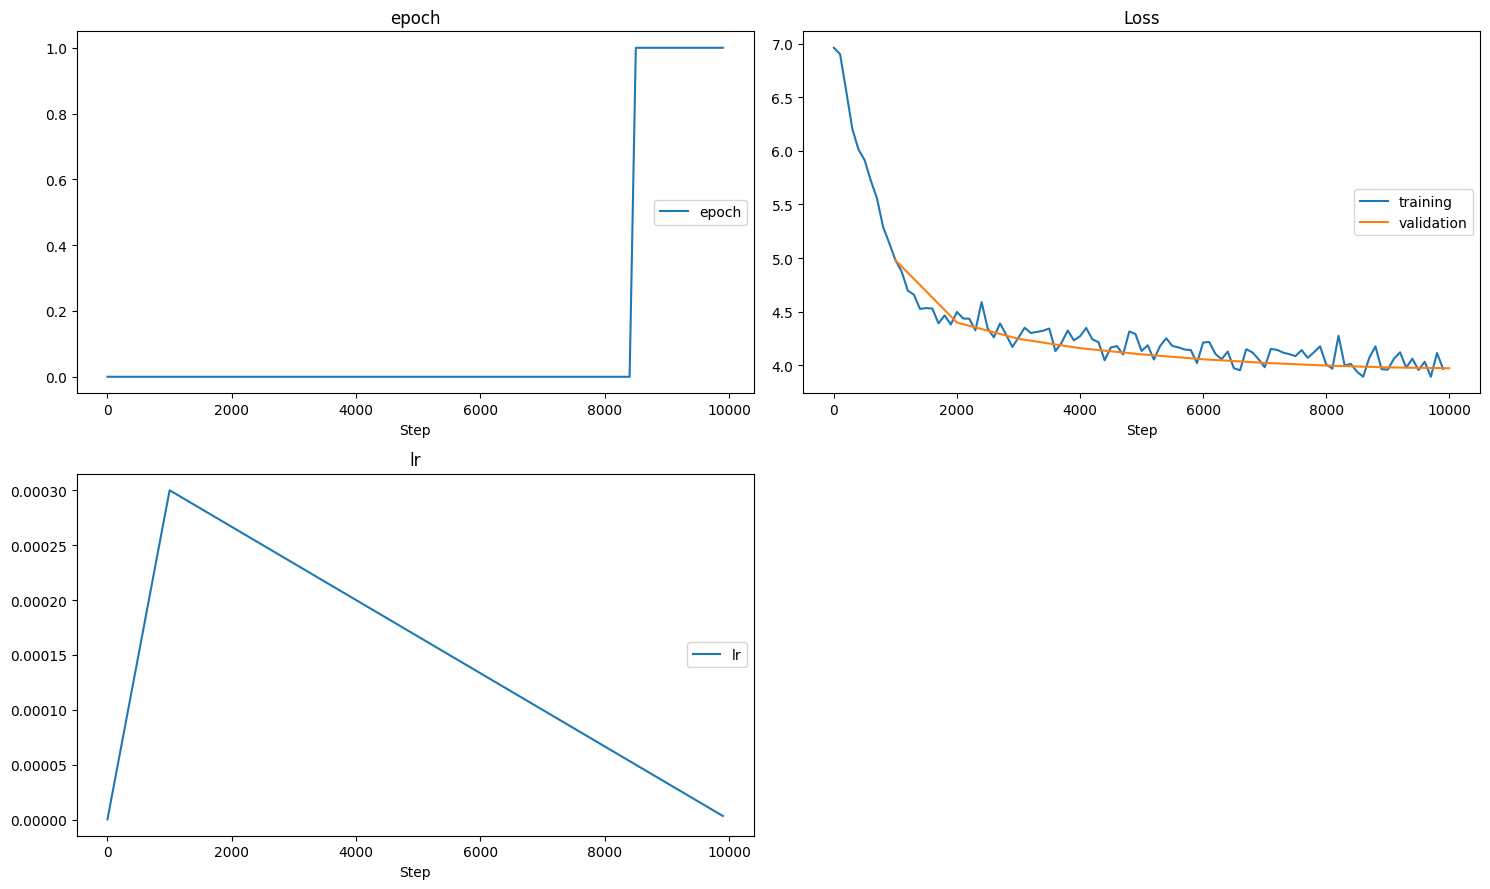

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    3.891, max:    6.962, cur:    3.965)
	validation       	 (min:    3.971, max:    4.980, cur:    3.971)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [26]:
# Обучение goes brrrr!

trainer.run(model, train_dataloader, test_dataloader)
local_path = save_model_locally(model, tokenizer, save_path="saved_models/nano_model")

# Загружаем модель на Hugging Face Hub
uploader = ModelUploader()
uploader.upload_to_hf(local_path, REPO_NAME)

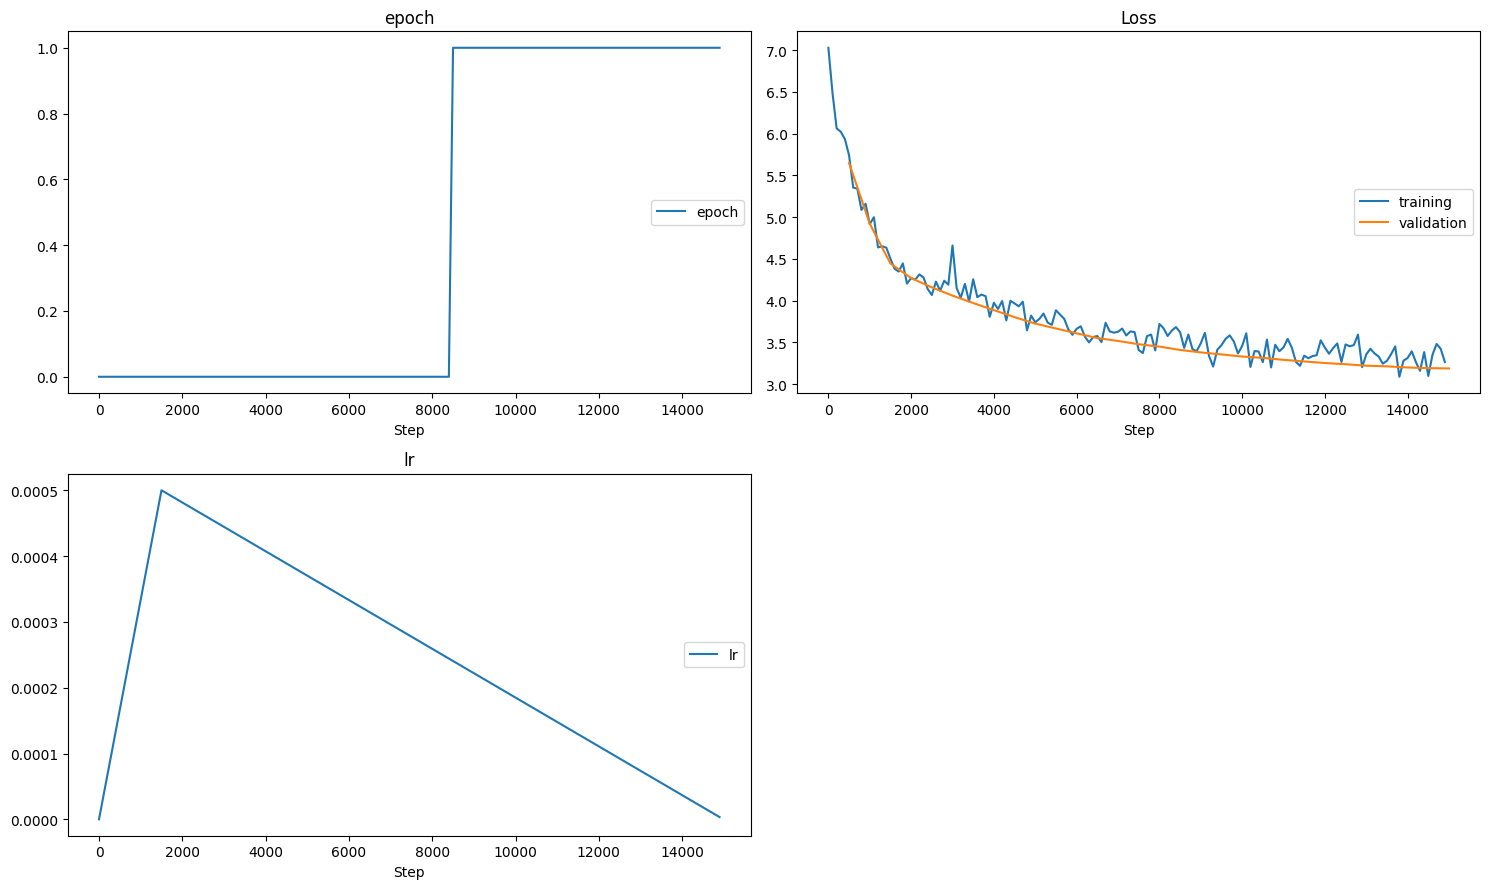

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    3.087, max:    7.029, cur:    3.264)
	validation       	 (min:    3.187, max:    5.649, cur:    3.187)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [27]:
# Загружаем mini модель и оптимизируем параметры
config = model_configs["mini"]
config.dropout = 0.2  
config.vocab_size = len(tokenizer.token2id)  


model = TransformerForCausalLM(config)

# Оптимизированные параметры обучения для mini модели
trainer = Trainer(
    learning_rate=5e-4,  # Более высокий learning rate для ускорения обучения
    weight_decay=0.05,   # Увеличенный weight decay для лучшей регуляризации
    clip_grad_norm=1.0,  # Контроль экстремальных градиентов
    n_steps=15_000,      # Больше шагов для лучшей сходимости
    val_every_n_steps=500,
    plot_every_n_steps=100,
)


trainer.run(model, train_dataloader, test_dataloader)
local_path = save_model_locally(model, tokenizer, save_path="saved_models/mini_model")

# Загружаем модель на Hugging Face Hub
uploader = ModelUploader()
uploader.upload_to_hf(local_path, REPO_NAME)

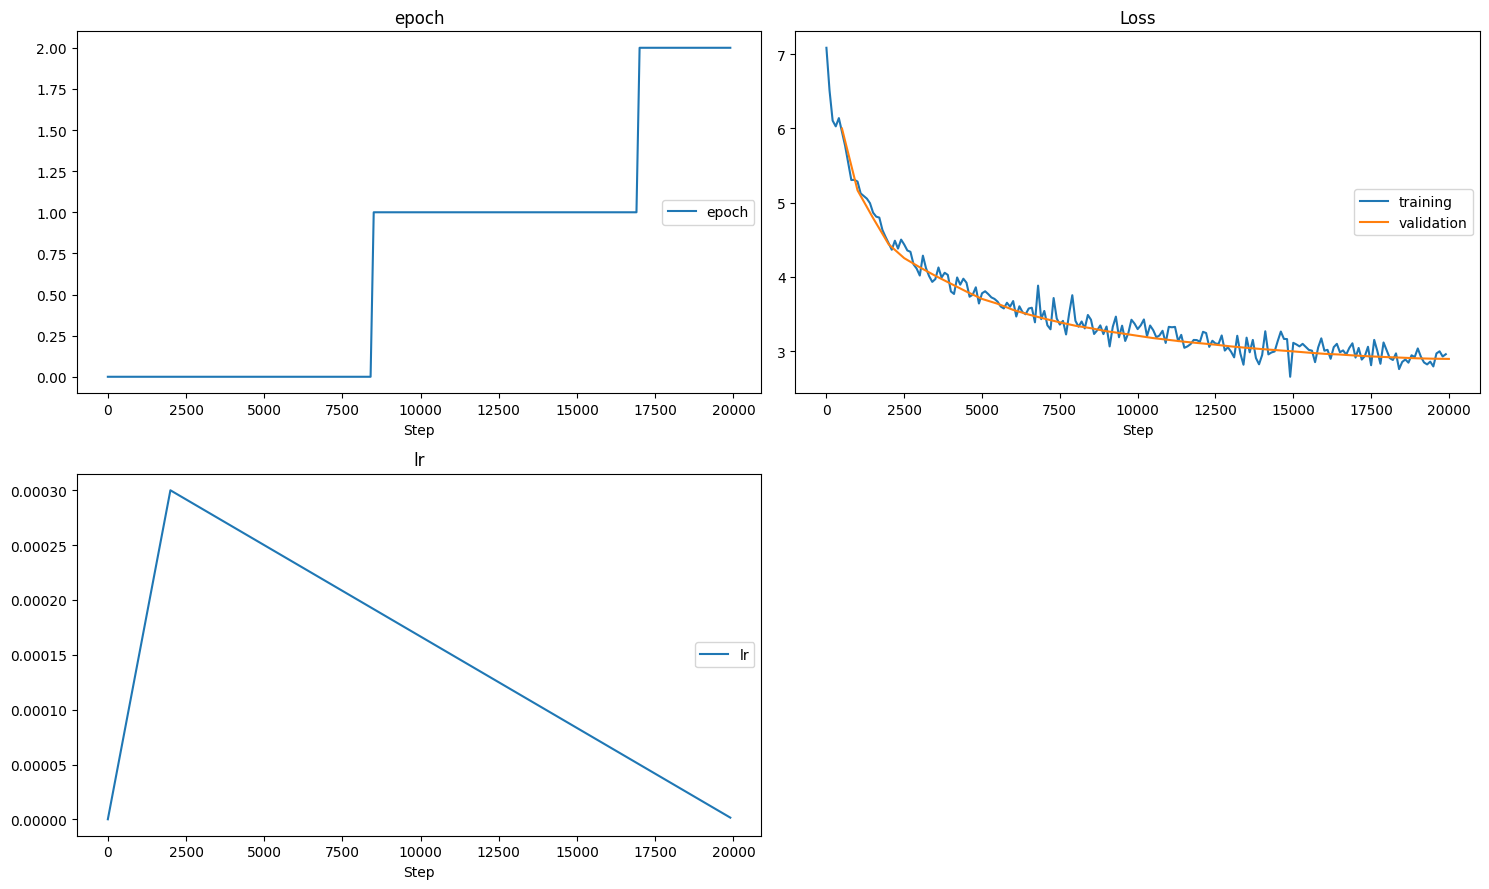

epoch
	epoch            	 (min:    0.000, max:    2.000, cur:    2.000)
Loss
	training         	 (min:    2.653, max:    7.085, cur:    2.957)
	validation       	 (min:    2.894, max:    5.998, cur:    2.894)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [28]:
# Загружаем small модель и оптимизируем параметры
config = model_configs["small"]
config.dropout = 0.25  # Более высокий dropout для большой модели
config.vocab_size = len(tokenizer.token2id)  # Устанавливаем размер словаря

# Создание модели
model = TransformerForCausalLM(config)

# Оптимизированные параметры обучения для small модели
trainer = Trainer(
    learning_rate=3e-4,  # Умеренный learning rate для стабильности
    weight_decay=0.1,    # Высокий weight decay для предотвращения переобучения
    clip_grad_norm=0.7,  # Более строгое ограничение градиентов
    n_steps=20_000,      # Больше шагов из-за большего количества параметров
    val_every_n_steps=500,
    plot_every_n_steps=100,
)

# Запускаем обучение small модели
trainer.run(model, train_dataloader, test_dataloader)
local_path = save_model_locally(model, tokenizer, save_path="saved_models/small_model")

# Загружаем модель на Hugging Face Hub
uploader = ModelUploader()
uploader.upload_to_hf(local_path, REPO_NAME)

In [27]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

# Загрузка словаря модели
model_path = hf_hub_download(repo_id=REPO_NAME, filename="saved_models/small_model.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(model_path, map_location=device, weights_only=False)

# Получаем конфигурацию из словаря
config = state_dict['config']

# Создаем модель с загруженной конфигурацией
model = TransformerForCausalLM(config)

# Загружаем веса из словаря
model.load_state_dict(state_dict['model_state_dict'])

# Переносим модель на нужное устройство и устанавливаем в режим оценки
model = model.to(device)
model.eval()

# Генерация текста
text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=device)[None, :]
model_output = model.generate(
    input_ids,
    max_new_tokens=150,           # Достаточно для завершения анекдота
    eos_token_id=tokenizer.eos_token_id,
    temperature=0.7,              # Слегка пониженная температура для более осмысленной генерации
    do_sample=True,               # Включаем семплирование для разнообразия
    top_k=50                      # Увеличенный top_k для расширенного контроля
)
tokenizer.decode(model_output[0].tolist())

Number of parameters: 79.45M


'Заходит в бар, а там медведь в магазин волк. Тут заходит мужик. Идет медсестру, смотрит - на пальце «Камеран (с). Подходит к бармену и говорит: - Бабушка, а кто это будет? - Как-то я дам. - Да ты что, сэр, у нас кота на плече. Открывает левый есно, а там все волк, он воны. Вдруг видит - армянин - на хлеба, а ты, а в школу не е'

In [88]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

NameError: name 'save_model_as_safetensor' is not defined

Поиграйтесь с гиперпараметрами, попробуйте обучить `mini` и `small` версии.
Постарайтесь добиться как можно более высокого качества как в терминах лосса, так и при визуальной оценке генерации.

### Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Реализовать Rotary Positional Embedding **[4 балла]**
- Реализовать Multi-Head Latent Attention **[2 балл]**
- Оформить репозиторий на 🤗: карточка модели с описанием задания, репортом качества и примерами генерации **[2 балл]**

Реализация Rotary Positional Embedding:

In [28]:
class RotaryEmbedding(nn.Module):
    """Ротационные позиционные эмбеддинги (RoPE)"""

    def __init__(self, dim: int, max_seq_len: int = 2048):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len

        
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

        
        self._reset_cos_sin_cache()

    def _reset_cos_sin_cache(self):
        
        seq_len = self.max_seq_len
        position = torch.arange(seq_len, dtype=torch.float)

        
        freqs = torch.outer(position, self.inv_freq)

        
        emb = torch.cat((freqs, freqs), dim=-1)
        cos_cache = emb.cos().unsqueeze(1)  
        sin_cache = emb.sin().unsqueeze(1)  

        self.register_buffer("cos_cached", cos_cache, persistent=False)
        self.register_buffer("sin_cached", sin_cache, persistent=False)

    def forward(self, x: Tensor, seq_dim: int = -2) -> Tensor:
        """
        Применяет ротационные позиционные эмбеддинги к входному тензору
        Args:
            x: входной тензор [batch_size, seq_len, dim]
            seq_dim: измерение последовательности
        """
        return self._apply_rotary_pos_emb(x, seq_dim)

    def _apply_rotary_pos_emb(self, x: Tensor, seq_dim: int = -2) -> Tensor:
        
        seq_len = x.shape[seq_dim]

        
        if seq_len > self.max_seq_len:
            self.max_seq_len = seq_len
            self._reset_cos_sin_cache()

        
        cos = self.cos_cached[:seq_len]
        sin = self.sin_cached[:seq_len]

        
        x_shape = x.shape
        x = x.view(*x_shape[:-1], -1, 2)
        x1, x2 = x.unbind(-1)

        
        out1 = x1*cos - x2*sin
        out2 = x2*cos + x1*sin

        
        out = torch.stack([out1, out2], dim=-1)
        out = out.view(*x_shape)

        return out

Модификация класса CausalSelfAttention для использования RoPE вместо ALiBi:

In [29]:

class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and Rotary Positional Embedding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

       
        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)
        self.kv_proj = nn.Linear(self.config.hidden_dim, 2 * self.config.n_kv_head * self.head_dim, bias=False)
        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        
        self.rotary_emb = RotaryEmbedding(dim=self.head_dim, max_seq_len=self.config.max_seq_len)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1)
        mask = 1.0 - mask
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        batch_size, seq_len, hidden_dim = x.shape

        
        q = self.q_proj(x)  

        
        kv = self.kv_proj(x)  
        kv = kv.view(batch_size, seq_len, 2, self.config.n_kv_head, self.head_dim)
        k, v = kv.unbind(dim=2)  

        
        q = q.view(batch_size, seq_len, self.config.n_head, self.head_dim)

        
        q = q.transpose(1, 2)  
        k = k.transpose(1, 2)  
        v = v.transpose(1, 2)  

        
        if self.q_per_kv > 1:
            k = k.repeat_interleave(self.q_per_kv, dim=1)  
            v = v.repeat_interleave(self.q_per_kv, dim=1)  

        q = self.rotary_emb(q, seq_dim=2)
        k = self.rotary_emb(k, seq_dim=2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  

        causal_mask = self.causal_mask[:, :, :seq_len, :seq_len]
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))

        if attention_mask is not None:
            pad_mask = attention_mask.view(batch_size, 1, 1, seq_len)
            attn_scores = attn_scores.masked_fill(pad_mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        out = torch.matmul(attn_weights, v)  

        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)

        out = self.out_proj(out)

        return out

Реализация Multi-Head Latent Attention (MHLA):

In [30]:
class MultiHeadLatentAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Multi-Head Latent Attention использует латентные переменные для оптимизации вычислений"""
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0

        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.latent_dim = min(32, self.head_dim)  
        self.scale = self.head_dim**-0.5

        
        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)
        self.k_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)
        self.v_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)

        
        self.latents = nn.Parameter(
            torch.randn(1, self.config.n_head, self.latent_dim, self.head_dim) * 0.02
        )

        
        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)
        self.attn_dropout = nn.Dropout(self.config.dropout)

        
        self.rotary_emb = RotaryEmbedding(dim=self.head_dim, max_seq_len=self.config.max_seq_len)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Создание каузальной маски"""
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1)
        mask = 1.0 - mask
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        batch_size, seq_len, hidden_dim = x.shape

        
        q = self.q_proj(x).view(batch_size, seq_len, self.config.n_head, self.head_dim)
        k = self.k_proj(x).view(batch_size, seq_len, self.config.n_head, self.head_dim)
        v = self.v_proj(x).view(batch_size, seq_len, self.config.n_head, self.head_dim)

        
        q = q.transpose(1, 2)  
        k = k.transpose(1, 2)  
        v = v.transpose(1, 2)  

        
        q = self.rotary_emb(q, seq_dim=2)
        k = self.rotary_emb(k, seq_dim=2)

        
        latents = self.latents.expand(batch_size, -1, -1, -1)  

        
        latent_to_k = torch.matmul(latents, k.transpose(-2, -1))  

        
        causal_mask = self.causal_mask[:, :, :self.latent_dim, :seq_len]
        latent_to_k = latent_to_k.masked_fill(causal_mask == 0, float('-inf'))

        
        if attention_mask is not None:
            pad_mask = attention_mask.view(batch_size, 1, 1, seq_len)
            latent_to_k = latent_to_k.masked_fill(pad_mask == 0, float('-inf'))

       
        latent_to_k_weights = F.softmax(latent_to_k * self.scale, dim=-1)
        latent_to_k_weights = self.attn_dropout(latent_to_k_weights)

        
        latent_values = torch.matmul(latent_to_k_weights, v)  

        
        q_to_latent = torch.matmul(q, latent_values.transpose(-2, -1))  
        q_to_latent_weights = F.softmax(q_to_latent * self.scale, dim=-1)
        q_to_latent_weights = self.attn_dropout(q_to_latent_weights)

        out = torch.matmul(q_to_latent_weights, latent_values)  

        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)

        out = self.out_proj(out)

        return out

Модификация класса Block для использования MHLA:

In [31]:
class Block(nn.Module):
    def __init__(self, config: TransformerConfig, use_mhla: bool = False):
        """Base Transformer Block
        - Causal Self-Attention or Multi-Head Latent Attention
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)

        
        if use_mhla:
            self.attn = MultiHeadLatentAttention(config)
        else:
            self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

        
        

# Специальный раздел для проверяющего

In [32]:
device = torch.device("cuda")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Number of parameters: 79.45M


NameError: name 'safetensors' is not defined

In [33]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text), device=device)
model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

NameError: name 'check_model' is not defined